<a href="https://www.kaggle.com/code/firojpaudel/cohort-34-challenge?scriptVersionId=218159920" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

> Welcome to the notebook! This is my submission notebook file for the [Fellowship.ai](https://www.fellowship.ai/) Cohort 34, NLP challenge.

First, let's analyze dataset. Link to the dataset: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/discussion?sort=hotness)

In [1]:
# !pip install transformers datasets torch

In [2]:
#@ Since I'm using Kaggle's notebook itself, I don't need to import kaggle and stuffs.
import pandas as pd 

ds = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

## Preprocessing.... 

---

In [3]:
ds.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


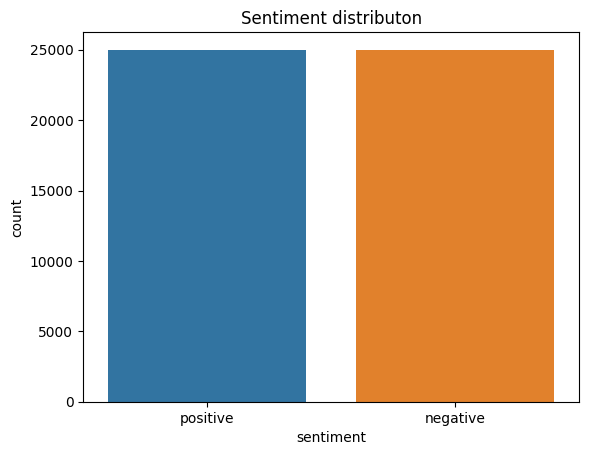

In [4]:
##@ Looking at dataset distribution

import seaborn as sns 
import matplotlib.pyplot as plt 

sns.countplot(data= ds, x='sentiment')
plt.title('Sentiment distributon')
plt.show()

So, the dataset contains **equal number of positive and negative sentiments**

In [5]:
ds.columns = ds.columns.str.strip()

In [6]:
##@ Converting sentiments to binary values: its easier to process that way 
ds['sentiment'] = ds['sentiment'].map({'positive': 1, 'negative': 0})

In [7]:
import re

##@ Also I see some html tags in dataset, so cleaning them
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  ##added later on to remove all characters that were not letters or whitespace
    return text.strip()

ds['review']= ds['review'].apply(clean_text)

ds['review'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object

In [8]:
 ##@ Also checking if there are any NULL values 
print(ds.isnull().sum())

review       0
sentiment    0
dtype: int64


That's good.. No Null values 😲

---

## Implementation phase ... 

---

Okay so I will just finetune the Hugging face model — _"distilbert-base-uncased"_.

In [9]:
## Getting rid of warnigs to make it more readable
import warnings

warnings.filterwarnings('ignore')

In [10]:
## Okay so I analyzed the dataset using pandas. Now converting this to HF dataset
from datasets import Dataset

dataset = Dataset.from_pandas(ds)

dataset

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})

In [11]:
## Tokenizing 
from transformers import AutoTokenizer 

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenizer_function(texts):
    return tokenizer(texts["review"], padding="max_length", truncation= True)

tokenized_dataset = dataset.map(tokenizer_function, batched= True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Preparing the dataset before passing into the model

In [12]:
from torch.utils.data import DataLoader 

## removing the reviews columns since its already tokenized in function and we no longer need it 
tokenized_dataset = tokenized_dataset.remove_columns(['review'])

##renaming the sentiments as labels since its standard format in libraries 
tokenized_dataset = tokenized_dataset.rename_column('sentiment', 'labels')

## converting to the pytorch tensors 
tokenized_dataset.set_format('torch')

Now since I want the evaluation results as well, breaking down the dataset to training and validation/test sets... 

In [13]:
train_test = tokenized_dataset.train_test_split(test_size=0.2)  #80:20 ratio
train_dataset = train_test["train"]
test_dataset = train_test["test"]

In [14]:
## Setting the model
from transformers import AutoModelForSequenceClassification 

model= AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Will use Trainer method.

In [15]:
from transformers import TrainingArguments, Trainer, TrainerCallback

training_args = TrainingArguments(
    output_dir="./sentiments",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [16]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value= user_secrets.get_secret("wandb_api_key")

In [17]:
import wandb
wandb.login(key= secret_value)
wandb.init(project="Sentiment_analysis", name="V01_R1")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: firojpaudel (firojpaudel-madan-bhandari-memorial-college). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250118_095349-01fd0hg3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run V01_R1
wandb: ⭐️ View project at https://wandb.ai/firojpaudel-madan-bhandari-memorial-college/Sentiment_analysis
wandb: 🚀 View run at https://wandb.ai/firojpaudel-madan-bhandari-memorial-college/Sentiment_analysis/runs/01fd0hg3


In [18]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,0.214900,0.200370
2,0.141200,0.227190
3,0.090000,0.274337


TrainOutput(global_step=7500, training_loss=0.1660027079264323, metrics={'train_runtime': 3560.6903, 'train_samples_per_second': 33.701, 'train_steps_per_second': 2.106, 'total_flos': 1.589608783872e+16, 'train_loss': 0.1660027079264323, 'epoch': 3.0})

In [19]:
## Finally evaluating the results 

results = trainer.evaluate()

print(results)

{'eval_loss': 0.27433741092681885, 'eval_runtime': 77.1628, 'eval_samples_per_second': 129.596, 'eval_steps_per_second': 8.1, 'epoch': 3.0}


Might was well visualize the metrics:

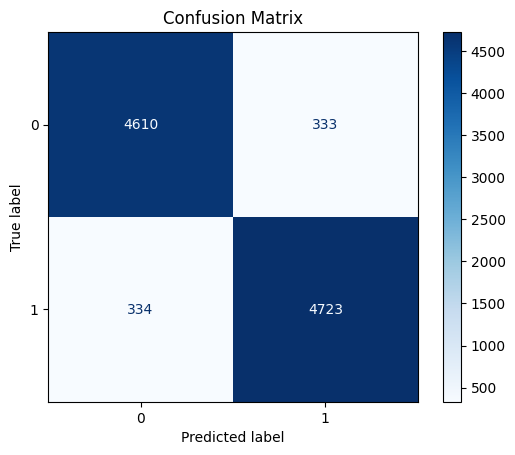

              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      4943
    Positive       0.93      0.93      0.93      5057

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [20]:
## Confusion Matrix and classificationreport as well
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import numpy as np

# Predictions on the test set
predictions = trainer.predict(test_dataset)
y_true = np.array(test_dataset["labels"])
y_pred = np.argmax(predictions.predictions, axis=1)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

In [21]:
## Saving the finetuned model.. Incase I need for future use case 

model.save_pretrained('./senti_finetuned')
tokenizer.save_pretrained('./senti_finetuned')

('./senti_finetuned/tokenizer_config.json',
 './senti_finetuned/special_tokens_map.json',
 './senti_finetuned/vocab.txt',
 './senti_finetuned/added_tokens.json',
 './senti_finetuned/tokenizer.json')

In [22]:
## compressing the folder before saving
!zip -r sentiment_imdb.zip /kaggle/working/senti_finetuned

  adding: kaggle/working/senti_finetuned/ (stored 0%)
  adding: kaggle/working/senti_finetuned/vocab.txt (deflated 53%)
  adding: kaggle/working/senti_finetuned/model.safetensors (deflated 8%)
  adding: kaggle/working/senti_finetuned/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/senti_finetuned/tokenizer.json (deflated 71%)
  adding: kaggle/working/senti_finetuned/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/senti_finetuned/config.json (deflated 46%)


## Testing phase ... 

---

In [23]:
# Loading the finetuned model:

f_model= AutoModelForSequenceClassification.from_pretrained('/kaggle/working/senti_finetuned')
f_tokenizer = AutoTokenizer.from_pretrained('/kaggle/working/senti_finetuned')

Could have just used the pipeline --> "sentiment_analysis" but trying a lengthier way...

In [24]:
## preparing some lists of reviews to pass into the finetuned model 

texts = [
    "Ahhh, it was meh. Music was good but the action was so bad. Couldn't even bear the whole thing and dropped.", 
    "I love the couple. They are just made for each other", 
    "The pacing of the film is also impeccable. It moves steadily forward, never lingering too long on one plot point, but taking its time to explore the nuances of the characters' internal struggles. The script is sharp, witty, and thought-provoking, offering moments of levity amid the tension, and the score by renowned composer Michael Porter elevates every scene with its hauntingly beautiful orchestral arrangements", 
    "While the cinematography is competent, it doesn’t add much to the film’s overall atmosphere. The bleak and dark tones, which are meant to reflect the impending disaster, become monotonous and uninteresting after a while. Instead of building tension, the visuals start to feel repetitive and uninspired.",
    "The Tale of a Lost Sock: Once upon a time, there was a sock, / Who got lost from its cozy flock. / It slipped and it tripped, / In the laundry it dipped, / And now it just wants to talk! / It said, 'Where is my pair? I feel bare!' / As it roamed the laundry room, through the air.",
    "The film had stunning visuals and a captivating soundtrack, but the storyline was convoluted and the characters lacked depth."
]

In [25]:
#@ tokenizing the input texts

inputs = f_tokenizer(texts, padding= True, truncation= True, max_length= 512, return_tensors='pt')

In [26]:
##@ Using GPU if available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f_model = f_model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

In [27]:
## Getting  the predictions
with torch.no_grad():
    outputs = f_model(**inputs)

In [28]:
## Computing prob and predicts

probab = torch.nn.functional.softmax(outputs.logits, dim=-1)
prediction = torch.argmax(probab, dim=-1)

In [29]:
## Mapping predictions to labels
labels = {0: "Negative", 1: "Positive"}
results = []

for i, text in enumerate(texts):
    label_id = prediction[i].item()
    confidence = probab[i][label_id].item()
    sentiment = labels[label_id]
    results.append({
        "text": text,
        "sentiment": sentiment,
        "confidence": confidence
    })

## Display the results
for result in results:
    print(f"Text: {result['text']}")
    print(f"Sentiment: {result['sentiment']} (Confidence: {result['confidence']:.4f})")
    print()

Text: Ahhh, it was meh. Music was good but the action was so bad. Couldn't even bear the whole thing and dropped.
Sentiment: Negative (Confidence: 0.9979)

Text: I love the couple. They are just made for each other
Sentiment: Positive (Confidence: 0.9965)

Text: The pacing of the film is also impeccable. It moves steadily forward, never lingering too long on one plot point, but taking its time to explore the nuances of the characters' internal struggles. The script is sharp, witty, and thought-provoking, offering moments of levity amid the tension, and the score by renowned composer Michael Porter elevates every scene with its hauntingly beautiful orchestral arrangements
Sentiment: Positive (Confidence: 0.9983)

Text: While the cinematography is competent, it doesn’t add much to the film’s overall atmosphere. The bleak and dark tones, which are meant to reflect the impending disaster, become monotonous and uninteresting after a while. Instead of building tension, the visuals start to f

It's working pretty fine tbh.

---